# Packages:

In [277]:
import torch
import scipy
import copy
import scipy.linalg
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Neural Network:

In [2]:
class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, bias=False):
        
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, output_dim, bias=bias)
        
    def forward(self, X):
        
        """
        X: [batch_size, input_dim], float tensor
        """
        
        if (X.type() != 'torch.FloatTensor'):
            X = X.type(torch.FloatTensor)
        
        X = F.relu(self.linear1(X))
        H = self.linear2(X)
        
        # H: [batch_size, output_dim], the feature representation
        return H

# A_tilde Calculation:

In [3]:
def calculate_Atilde(A, K, alpha):
    
    
    """
    A: adjacent matrix, numpy array, [N, N]
    K: number of power iterations, scalar
    alpha: jump probability, scalar
    """
    
    
    # Number of nodes in this graph
    N = A.shape[0]
    
    # Add a self loop
    A = A + np.identity(N)
    
    # Update the degree matrix (Because the added self-loops)
    D = np.diag(np.sum(A, axis=1))
    
    # Calculate A_hat and (D^{1/2})^{-1}
    D_sqrt_inv = scipy.linalg.inv(scipy.linalg.sqrtm(D))
    A_hat = D_sqrt_inv @ A @ D_sqrt_inv
    
    
    # Power iteration: A_tilde = (1-\alpha)(\sum_{i=0}^{K} \alpha^{i}\hat{A}^{i})
    A_tilde = np.zeros((N,N))
    A_hat_i = np.identity(N)
    alpha_i = 1
    for i in range(0, K+1):
        A_tilde = A_tilde + alpha_i*A_hat_i
        alpha_i = alpha_i*alpha
        A_hat_i = A_hat_i @ A_hat
    A_tilde = (1-alpha)*A_tilde
    
    # A_tilde: [N, N], 2-d float tensor
    return torch.tensor(A_tilde).type(torch.FloatTensor)

# cSBM Generator:

In [144]:
class cSBM:
    
    def __init__(self, N, p, d, mu, l):
        
        """
        N: number of nodes
        p: dimension of feature vector 
        d: average degree
        l: lambda, hyperparameter
        mu: mu, hyperparameter
        
        For details: https://arxiv.org/pdf/1807.09596.pdf
        and https://openreview.net/pdf/3fd51494885a4f0252dd144ae51025065fef2186.pdf
        """
        
        
        # Generate class from {-1, 1} for each node
        v = np.random.choice(a = [-1, 1],
                             size = N,
                             replace = True,
                             p = [0.5, 0.5])
        
        class1_ids = np.argwhere(v==1)
        
        class2_ids = np.argwhere(v==-1)
        
        
        # Mask -1 to 0 and store the result in v_mask
        v_mask = np.copy(v)
        v_mask[v==-1] = 0
        
        # calculate c_in and c_out
        c_in = d + np.sqrt(d)*l
        c_out = d - np.sqrt(d)*l
        
        
        # Generate a latent random vector u with size p
        u = np.random.normal(loc=0, scale=1/np.sqrt(p), size=p)
        
        # Generate the adjacent matrix without self-loop
        A = np.zeros((N,N))
        for i in range(N):
            for j in range(i+1, N):
                if (v[i] == v[j]):
                    if (np.random.choice(a = [1,0],p = [c_in/N, 1-c_in/N])):
                        A[i,j] = 1.0
                    else:
                        A[i,j] = 0.0
                else:
                    if (np.random.choice(a = [1,0],p = [c_out/N, 1-c_out/N])):
                        A[i,j] = 1.0
                    else:
                        A[i,j] = 0.0
        A = A + A.T
        
        # Save all the necessary parameters
        self.v = v
        self.v_mask = v_mask
        self.A = A
        self.u = u
        self.p = p
        self.N = N
        self.mu = mu
        xi = N/p
        self.phi = np.arctan((l*np.sqrt(xi))/mu)*(2/np.pi)
        self.threshold = l**2 + (mu**2)/(N/p)
        self.class1_ids = class1_ids.reshape(-1)
        self.class2_ids = class2_ids.reshape(-1)

# Node Class:

In [346]:
class Node:
    
    
    def __init__(self, local_model, node_idx, X, y):
        
        """
        local model: The local MLP model for each node
        node_idx: The unique index of a node
        X: [n_k, p], feature matrix, float tensor
        y: [n_k], true labels, long tensor
        """
        
        self.model = local_model
        self.idx = node_idx
        self.X = X
        self.y = y
        self.n_k = X.shape[0]
        self.dataloader = None
        
        
    def upload_local_parameters(self):
        
        """
        Upload local model parameters to central server.
        Usually used for aggregation step in each communication.
        """
        
        return self.model.state_dict()
    
    
    def receieve_central_parameters(self, central_parameters):
        
        """
        central_parameters: A state dictonary for central server parameters.
        
        Receive the broadcasted central parameters.
        """
        
        with torch.no_grad():
            for pname, param in self.model.named_parameters():
                param.copy_(central_parameters[pname])
                
                
    def upload_h(self):
        
        
        """
        This function uploads an random hidden vector from a node to the central server.
        It also calculate and upload a dictonary of gradients  (dh/dw, 3D tensors) for each parameter w.r.t the local model
        """ 
        
        
        # x: [p]
        x = self.X[np.random.choice(a=self.n_k),:]
        
        # Clear the possible accumulated gradient of the parameters of local model
        self.model.zero_grad()
        
        h = self.model(x).view(1, -1)
        
        num_class = h.shape[-1]
        
        dh = {}
        
        for i in range(num_class):
            
            h[0, i].backward(retain_graph=True)
            
            for pname, param in self.model.named_parameters():
                
                if pname in dh:
                    dh[pname].append(param.grad.data.clone())
                else:
                    dh[pname] = []
                    dh[pname].append(param.grad.data.clone())
                    
                if (i == num_class-1):
                    d1, d2 = dh[pname][0].shape
                    dh[pname] = torch.cat(dh[pname], dim=0).view(num_class, d1, d2)
                    
            self.model.zero_grad()
        
        return h, dh
    
    def local_update(self, A_tilde_k, C_k, dH, I, pi, 
                     opt, learning_rate=0.01, num_epochs=10):
        
        """
        The local update process for a node k.
        A_tilde_k: The kth row of PageRank matrix A_tilde.
        C_k: [1, num_class] The aggregated neighborhood information for node k.
        dH: A list of gradient dictonaries, where the kth dictonary contains the gradients of each parameter for node k.
        I: Number of local updates.
        opt: Optimizer used for local updates: SGD or Adam.
        learning rate: learning rate for SGD.
        
        To-Do:
        Number of "epochs"
        Gradient Clipping
        """
        
        batch_size = int(np.floor(self.n_k/I))
        
        if (self.dataloader == None):
            dataset = torch.utils.data.TensorDataset(self.X, self.y)
            self.dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            
        k = self.idx
        
        N = len(dH)
        
        num_class = C_k.shape[-1]
        
        if (opt == "Adam"):
            optimizer = optim.Adam(self.model.parameters())
            
        else:
            optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
            
        for epoch in range(num_epochs):

            node_train_loss = 0

            for X_B, y_B in self.dataloader:

                optimizer.zero_grad()
                
                B = X_B.shape[0]
            
                H_B = self.model(X_B)
                y_B_onehot = torch.zeros(B, num_class)
                y_B_onehot[np.arange(B), y_B] = 1

                Z_B = A_tilde_k[k]*H_B + C_k
                y_B_hat = F.softmax(Z_B, dim=1)
                batch_loss = F.nll_loss(torch.log(y_B_hat), y_B, reduction="sum")

                with torch.no_grad():
                    Errs = y_B_hat - y_B_onehot
                    node_train_loss += batch_loss.item()/B
                    
                batch_loss.backward()
                
                with torch.no_grad():
                    for pname, param in self.model.named_parameters():
                        for i in range(N):
                            if (i != k):
                                param.grad.data += A_tilde_k[i]*torch.tensordot(Errs, dH[i][pname], dims=1).sum(dim=0)
                        param.grad.data = param.grad.data/B
                optimizer.step()
                
        return node_train_loss/len(self.dataloader)
    
    def local_eval(self, central_model, A_tilde_kk, C_k):
        
        count = 0
        
        with torch.no_grad():
            H = central_model(self.X)
            y_hat = F.softmax(A_tilde_kk*H+C_k, dim=1)
            loss = F.nll_loss(torch.log(y_hat), self.y, reduction="mean")
            preds = torch.max(y_hat, dim=1)[1]
            count = (preds == self.y).sum().item()
            
        return loss.item(), count/self.n_k

# Central Server Class:

In [348]:
class Central_Server:
    
    def __init__(self, node_list, A_tilde):
        
        """
        A_tilde: PageRank matrix
        node_list: A list contains objects from Node class
        """
        
        self.A_tilde = A_tilde
        self.node_list = node_list
        self.N = len(node_list)
        self.central_parameters = None
        self.cmodel = None
        
    def init_central_parameters(self, input_dim, hidden_dim, output_dim):
        
        """
        Initialize the central server parameter dictonary
        """
        
        self.cmodel = MLP(input_dim, hidden_dim, output_dim)
        
        self.central_parameters = copy.deepcopy(self.cmodel.state_dict())
        
        
    def broadcast_central_parameters(self):
        
        """
        Broadcast the current central parameters to all nodes.
        Usually used after the aggregation in the end of each communication
        """
        
        if self.central_parameters == None:
            raise ValueError("Central parameters is None, Please initilalize it first.")
        
        for node in self.node_list:
            node.receieve_central_parameters(self.central_parameters)
        
    def collect_hs(self):
        
        """
        Collect h and dh from each node
        """
        
        H = []
        dH = []
        
        for i in range(self.N):
            h_i, dh_i = self.node_list[i].upload_h()
            H.append(h_i)
            dH.append(dh_i)
        
        # H: [N, num_class]
        H = torch.cat(H, dim=0)
        
        # dH: a list of gradient dictonaries
        return H, dH
        
        
    def communication(self, train_indices, test_indices, I, aggregation, opt, learning_rate, num_epochs):
        
        """
        train_indices: A list of indices for the nodes that will be used during training
        I: Number of local updates
        learning: Learning rate
        opt: The name of the optimizer used for training.
        aggregation: The function to aggregate the local parameters from the nodes used in training.
        """
        
        self.broadcast_central_parameters()
        
        # H: [N, num_classes]
        H, dH = self.collect_hs()
        
        with torch.no_grad():
            H_copy = torch.clone(H).detach()
            C = torch.matmul(self.A_tilde, H_copy)
            
        total_train_loss = 0
        
        total_test_loss = 0
        
        test_accuracy = 0
        
        pi = train_indices[0]
            
        for k in train_indices:
            
            C_k = C[k,:] - self.A_tilde[k,k]*H_copy[k,:]
            
            total_train_loss += self.node_list[k].local_update(self.A_tilde[k,:], C_k, dH, 
                                           I, pi, opt, learning_rate, num_epochs)
            
        aggregation(self.central_parameters, self.cmodel, self.node_list, train_indices)
    
        for k in test_indices:
            C_k = C[k,:] - self.A_tilde[k,k]*H_copy[k,:]
            anloss, naccuracy = self.node_list[k].local_eval(self.cmodel, self.A_tilde[k,k], C_k)
            
            total_test_loss += anloss
            test_accuracy += naccuracy
            
        
        return total_train_loss/len(train_indices), total_test_loss/len(test_indices), test_accuracy/len(test_indices)

# Average Aggregation:

In [349]:
def mean_agg(central_parameters, central_model, node_list, train_indices):
    
    num_train = len(train_indices)
    
    with torch.no_grad():
        
        for pname, param in central_model.named_parameters():
            
            p = node_list[train_indices[0]].model.state_dict()[pname]
            
            for i in range(1, num_train):
                
                p = p + node_list[train_indices[i]].model.state_dict()[pname]
            
            p = p/num_train
            
            central_parameters[pname] = p
            
            param.copy_(p)

# cSBM Training

In [355]:
def train_CSBM(csbm, A_tilde, hidden_dim, 
               n_k, I, num_communication, aggregation,
               num_train, learning_rate=0.1, opt="Adam", num_epochs=10):
    
    """
    csbm: An cSBM object (contextual stochastic block model)
    A_tilde: pageRank matrix
    n_k: number of feature vectors each node has
    I: number of local updates for each node
    num_communication: Number of communicatons
    aggregation: aggregation method, a function
    num_train: Number of nodes used to train
    learning_rate: Learning rate for SGD
    opt: optimization method: Adam or SGD
    """
    
    N = A_tilde.shape[0]
    
    input_dim = csbm.p
    
    output_dim = 2
    
    node_list = []
    
    for i in range(N):
        
        X = []
        
        model_i = MLP(input_dim, hidden_dim, output_dim)
        
        for j in range(n_k):
            
            x_j = np.sqrt(csbm.mu/N)*csbm.v[i]*csbm.u + np.random.normal(loc=0, scale=1, size=csbm.p)/np.sqrt(csbm.p)
            
            X.append(x_j)
            
        X = torch.tensor(np.array(X))
        
        if csbm.v[i] == -1:
            
            y = np.zeros(n_k)
            
        elif csbm.v[i] == 1:
            
            y = np.ones(n_k)

        y = torch.tensor(y).type(torch.LongTensor)
        
        node_i = Node(local_model=model_i, node_idx=i, X=X, y=y)
        
        node_list.append(node_i)
        
    server = Central_Server(node_list, A_tilde)
    
    server.init_central_parameters(input_dim, hidden_dim, output_dim)
    
    class1_train = np.random.choice(a=csbm.class1_ids, size=int(num_train/2), replace=False)
    
    class2_train = np.random.choice(a=csbm.class2_ids, size=int(num_train/2), replace=False)
    
    train_indices = np.concatenate((class1_train, class2_train), axis=0)
    
    test_indices = list(set(np.arange(N)) - set(train_indices))
    
    train_loss = []
    
    test_loss = []
    
    test_acc = []
    
    for ith in range(num_communication):
        
        average_train_loss, average_test_loss, test_accuracy  = server.communication(train_indices, test_indices, 
                                                                        I, aggregation, opt, learning_rate, num_epochs)
        train_loss.append(average_train_loss)
        
        test_loss.append(average_test_loss)
        
        test_acc.append(test_accuracy)
        
        print ("Communication:", ith+1, "Average train loss:", average_train_loss,
               "Average test loss:", average_test_loss, "Test accuracy:", test_accuracy)
        
    return train_loss, test_loss, test_acc

In [356]:
a,b,c = train_CSBM(csbm=csbm, A_tilde=A_tilde, hidden_dim=200, n_k=40,
           I=2, num_communication=20, aggregation=mean_agg, num_train=20, num_epochs=100)

Communication: 1 Average train loss: 0.3562433129549026 Average test loss: 0.6971662253141403 Test accuracy: 0.475
Communication: 2 Average train loss: 0.3295503455400467 Average test loss: 0.6917898438870906 Test accuracy: 0.4765625
Communication: 3 Average train loss: 0.30272941052913666 Average test loss: 0.6819510966539383 Test accuracy: 0.7409374999999999
Communication: 4 Average train loss: 0.2715079945325851 Average test loss: 0.6644757330417633 Test accuracy: 0.7315625000000001
Communication: 5 Average train loss: 0.25720848739147184 Average test loss: 0.6717058844864369 Test accuracy: 0.7665624999999999
Communication: 6 Average train loss: 0.24167072385549546 Average test loss: 0.6772050760686398 Test accuracy: 0.6959374999999999
Communication: 7 Average train loss: 0.2209977704286575 Average test loss: 0.6450009368360042 Test accuracy: 0.6190625000000001
Communication: 8 Average train loss: 0.19908937662839893 Average test loss: 0.6352919042110443 Test accuracy: 0.87218750000

In [337]:
N = 100
p = 10
d = 5
mu = 1
l = 2
csbm = cSBM(N, p, d, mu, l)
A_tilde = calculate_Atilde(csbm.A, 100, 0.95)
csbm.phi

0.9001680340923813

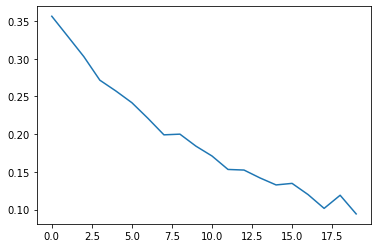

In [357]:
plt.plot(a)

In [ ]:
plt.plot(b)